In [1085]:
from convokit import Corpus, download
import multiprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from collections import Counter
import string
import re
import jsonlines
import json
import itertools
from csv import writer 
from tqdm import tqdm
import random

stop_words = stopwords.words('english')

In [2]:
corpus = Corpus(filename=download("reddit-corpus-small"))
corpus.print_summary_stats()

Dataset already exists at C:\Users\ben.prescott\.convokit\downloads\reddit-corpus-small
Number of Speakers: 119889
Number of Utterances: 297132
Number of Conversations: 8286


In [3]:
utt = corpus.utterances

In [388]:
utterances = []
for k,v in tqdm(utt.items()):
    values = {'id':v.id,
              'url':v.meta.get('permalink'),
              'speaker':v.speaker.id,
              'body':v.text,
              'subreddit':v.meta.get('subreddit')}
    utterances.append(values)

100%|██████████████████████████████████████████████████████████████████████| 297132/297132 [00:00<00:00, 373751.47it/s]


In [387]:
def clean_docs(uttlist):
    clean = uttlist
    clean = [i for i in clean if not (i['speaker'] == 'AutoModerator')]
    clean = [i for i in clean if not (i['body'] == '')]
    for item in tqdm(clean):
        for k,v in item.items():
            if k == 'body':
                punc = re.compile('[%s]' % re.escape(string.punctuation))
                stop_words_2 = [punc.sub('', w) for w in stop_words] #removing apostrophes as Reddit has cases of not using them
                tokens = v.split()
                tokens = [word for word in tokens if not word in stop_words]
                tokens = [word for word in tokens if not word in stop_words_2]
                tokens = [punc.sub('', w) for w in tokens]
                tokens = [word.lower() for word in tokens]
                tokens = [word for word in tokens if word.isalpha()]
                tokens = [word for word in tokens if len(word) > 3]
                item.update({k:tokens})
    clean = [i for i in clean if not ('deleted' in i['body'])]
    clean = [i for i in clean if not ('removed' in i['body'])]
    return clean

In [389]:
cleaned = clean_docs(utterances)

100%|████████████████████████████████████████████████████████████████████████| 292381/292381 [00:41<00:00, 7066.27it/s]


In [606]:
with jsonlines.open('utterances.jl','w') as writer:
    writer.write_all(cleaned)

# Corpus Data Review

In [390]:
df = pd.DataFrame(cleaned)

In [391]:
dfSorted = df.groupby('subreddit').count()
dfSorted = dfSorted.reset_index()
dfSorted = dfSorted.sort_values(by = 'id', ascending=False)

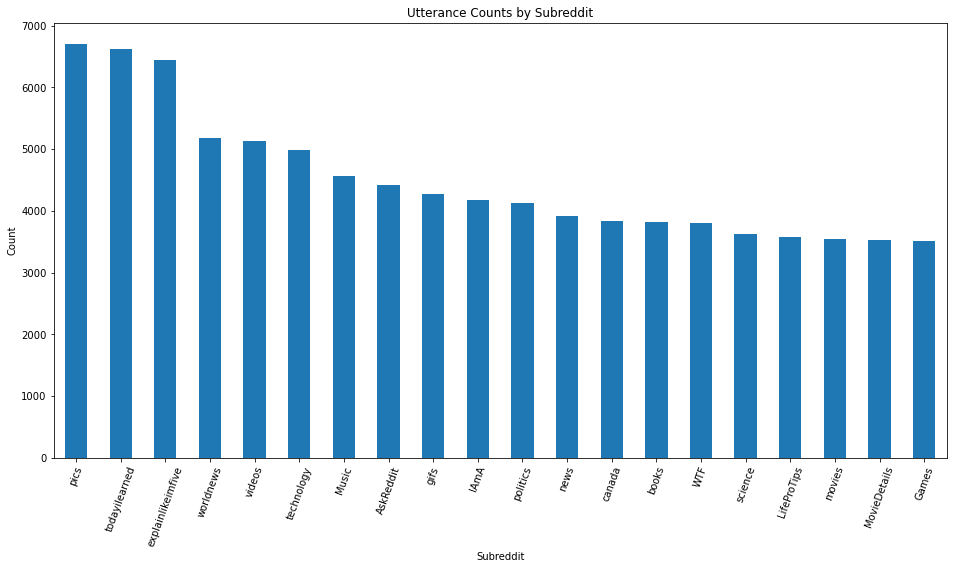

In [392]:
plt.figure(figsize=(16, 8))
ax = dfSorted['id'][:20].plot(kind='bar')
ax.set_title('Utterance Counts by Subreddit')
ax.set_xticklabels(dfSorted['subreddit'][:20], rotation=70)
ax.set_xlabel('Subreddit')
ax.set_ylabel('Count')
plt.show()

In [393]:
topSubs = list()
for sub in dfSorted['subreddit'][:20]:
    topSubs.append(sub)
topSubs

['pics',
 'todayilearned',
 'explainlikeimfive',
 'worldnews',
 'videos',
 'technology',
 'Music',
 'AskReddit',
 'gifs',
 'IAmA',
 'politics',
 'news',
 'canada',
 'books',
 'WTF',
 'science',
 'LifeProTips',
 'movies',
 'MovieDetails',
 'Games']

In [718]:
techDocs = list()
for value in range(len(cleaned)):
    value = cleaned[value]
    for k,v in value.items():
        if k == 'subreddit' and v == 'technology':
            values = {'id':value['id'], 'body':value['body']}
            techDocs.append(values)

In [719]:
len(techDocs)

4987

In [741]:
individualDocs = list()
combinedDocs = list()
vocabDocs = list()
for entry in techDocs:
    for k,v in entry.items():
        if k == 'body':
            vocab = Counter()
            vocab.update(v)
            individualDocs.append(v)
            combinedDocs.append(v)
            vocabDocs.append(vocab.most_common(10))
combinedDocs = list(itertools.chain.from_iterable(combinedDocs))            

In [742]:
vocab = Counter()
vocab.update(combinedDocs)
vocab.most_common(50)

[('people', 1304),
 ('like', 918),
 ('would', 639),
 ('think', 532),
 ('even', 529),
 ('this', 488),
 ('right', 467),
 ('that', 452),
 ('want', 444),
 ('thats', 443),
 ('companies', 440),
 ('also', 421),
 ('make', 417),
 ('time', 382),
 ('still', 369),
 ('they', 368),
 ('really', 349),
 ('much', 344),
 ('know', 340),
 ('good', 325),
 ('free', 306),
 ('government', 305),
 ('things', 304),
 ('need', 304),
 ('could', 300),
 ('company', 297),
 ('public', 293),
 ('something', 291),
 ('money', 280),
 ('internet', 279),
 ('there', 279),
 ('going', 277),
 ('cant', 273),
 ('access', 272),
 ('never', 270),
 ('actually', 265),
 ('work', 263),
 ('facebook', 262),
 ('thing', 261),
 ('point', 254),
 ('speech', 252),
 ('someone', 251),
 ('many', 242),
 ('service', 242),
 ('sure', 241),
 ('jones', 240),
 ('well', 233),
 ('every', 232),
 ('said', 227),
 ('google', 226)]

# Analyst Judgement

In [878]:
topTerms = ['people','companies','government','money']
vocDf = pd.DataFrame(columns=['id']+topTerms)

for item in techDocs:
    vocab = Counter()
    vocab.update(item['body'])
    for w,c in vocab.items():
        if w in topTerms:
            vocDf = vocDf.append({'id':item['id'], w:c}, ignore_index=True)
#             vocDf = vocDf.append({w:c}, ignore_index=True)
vocDf.fillna(0, inplace=True)
vocDf = vocDf.groupby(vocDf['id']).aggregate(sum)
vocDf.reset_index(inplace=True)

In [879]:
vocDf[:20]

,id,people,companies,government,money
0,e57wo99,1,0,0,0
1,e57yqwn,1,0,0,0
2,e57zyvr,1,0,0,0
3,e584g9n,0,0,0,1
4,e5888f2,4,0,0,3
5,e588iks,5,0,0,0
6,e58995l,5,1,0,0
7,e589caj,0,0,0,1
8,e58a1e7,4,1,0,0
9,e58al3o,2,0,0,1


In [881]:
vocDf.describe()

,people,companies,government,money
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.974589,0.328849,0.227952,0.209268
std,1.031710,0.649093,0.644565,0.531298
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000
max,9.000000,5.000000,6.000000,5.000000


# TF-IDF

In [883]:
newDocs = list()
for doc in individualDocs:
    strings = ' '.join(doc)
    newDocs.append(strings)

In [884]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(newDocs)
tfidf_tokens = tfidfvectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

In [885]:
ids = list()
for i in techDocs:
    for k,v in i.items():
        if k == 'id':
            ids.append(v)
df_tfidfvect.insert(0, 'id', ids)

In [886]:
df_tfidfvect[['people','companies','government','money']].describe()

,people,companies,government,money
count,4987.000000,4987.000000,4987.000000,4987.000000
mean,0.021855,0.009926,0.007343,0.006566
std,0.054140,0.041706,0.042195,0.038072
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.437744,0.564308,0.581140,1.000000


In [887]:
df_tfidf_short = df_tfidfvect[['id','people','companies','government','money']]
df_tfidf_short

,id,people,companies,government,money
0,9i5u2e,0.0,0.0,0.0,0.0
1,9ik0wa,0.0,0.0,0.0,0.0
2,e57um9l,0.0,0.0,0.0,0.0
3,e57uy17,0.0,0.0,0.0,0.0
4,e57v37y,0.0,0.0,0.0,0.0
...,...,...,...,...,...
4982,e6wwy2a,0.0,0.0,0.0,0.0
4983,e6wxtmq,0.0,0.0,0.0,0.0
4984,e6x3gkb,0.0,0.0,0.0,0.0
4985,e6x4uwp,0.0,0.0,0.0,0.0


In [888]:
analystIds = vocDf['id']

In [889]:
dfcompared = df_tfidf_short[df_tfidf_short['id'].isin(analystIds)]
dfcompared.reset_index(drop=True, inplace=True)

In [890]:
dfcompared[:20]

,id,people,companies,government,money
0,e57wo99,0.142247,0.000000,0.0,0.000000
1,e57yqwn,0.162799,0.000000,0.0,0.000000
2,e57zyvr,0.112136,0.000000,0.0,0.000000
3,e58bm4c,0.193906,0.000000,0.0,0.000000
4,e584g9n,0.000000,0.000000,0.0,0.100459
5,e5888f2,0.200862,0.000000,0.0,0.228899
6,e588iks,0.240686,0.000000,0.0,0.000000
7,e58995l,0.167349,0.045117,0.0,0.000000
8,e589caj,0.000000,0.000000,0.0,0.099602
9,e58a1e7,0.114352,0.038537,0.0,0.000000


# Doc2Vec

In [941]:
docs2 = list()
counter = 0
for i in techDocs:
    for k,v in i.items():
        if k == 'body':
            docs2.append(TaggedDocument(v,[counter]))
            counter += 1

In [ ]:
model = Doc2Vec(docs2, vector_size = 4, window=2, min_count=1, workers = 4)

In [949]:
d2vDF = pd.DataFrame(model.dv.vectors)
d2vDF.insert(0, 'id', ids)

In [950]:
d2vcompared = d2vDF[d2vDF['id'].isin(analystIds)]
d2vcompared.reset_index(drop=True, inplace=True)

In [952]:
d2vcompared[:20]

,id,0,1,2,3
0,e57wo99,0.020440,-0.127778,0.269114,0.328197
1,e57yqwn,0.203584,-0.137983,0.235256,0.148826
2,e57zyvr,0.107553,0.069734,0.118713,0.395098
3,e58bm4c,-0.147233,-0.246082,-0.086856,0.131670
4,e584g9n,0.629690,0.102222,0.571931,0.774755
5,e5888f2,0.710737,-0.008459,0.800173,0.697140
6,e588iks,0.662877,-0.014798,0.514976,0.997093
7,e58995l,0.530557,-0.365941,0.995237,1.803239
8,e589caj,0.586812,-0.135210,0.964407,0.819476
9,e58a1e7,0.612802,-0.166453,0.972527,1.964902


# Random Forest Classifiers

In [1710]:
MAX_NGRAM_LENGTH = 2
VECTOR_LENGTH = 400
SET_RANDOM = 100

In [1500]:
train_tokens = []
train_text = []
train_labels = []

test_tokens = []
test_text = []
test_labels = []

In [1501]:
cleaned_reduced = list()
for item in cleaned:
    for k,v in item.items():
        if k == 'subreddit' and v == 'technology' or v == 'todayilearned':
            cleaned_reduced.append(item)

In [1503]:
#Train data
random.shuffle(cleaned_reduced)
for num in range(500):
    choice = random.choice(cleaned_reduced)
    for k,v in choice.items():
        if k == 'body':
            train_tokens.append(v)
            strings = ' '.join(v)
            train_text.append(strings)
        if k == 'subreddit':
            train_labels.append(v)

In [1504]:
#Test Data
for num in range(500):
    choice = random.choice(cleaned_reduced)
    for k,v in choice.items():
        if k == 'body':
            test_tokens.append(v)
            strings = ' '.join(v)
            test_text.append(strings)
        if k == 'subreddit':
            test_labels.append(v)

## TF-IDF Classifier

In [1711]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
tfidf_vectors = tfidf_vectorizer.fit_transform(train_text)

In [1712]:
tfidf_vectors_test = tfidf_vectorizer.transform(test_text)

In [1713]:
tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = SET_RANDOM)

In [1714]:
tfidf_clf.fit(tfidf_vectors, train_labels)

RandomForestClassifier(max_depth=10, random_state=100)

In [1715]:
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)

In [1716]:
print('\nTF-IDF/Random forest F1 classification performance in test set:',
      round(metrics.f1_score(test_labels, tfidf_pred, average='macro'), 3))


TF-IDF/Random forest F1 classification performance in test set: 0.623


## Count Vectorizer Classifier

In [1737]:
count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
count_vectors = count_vectorizer.fit_transform(train_text)
count_vectors_test = count_vectorizer.transform(test_text)

In [1738]:
count_clf.fit(count_vectors, train_labels)

RandomForestClassifier(max_depth=10, random_state=100)

In [1739]:
count_pred = count_clf.predict(count_vectors_test) 

In [1740]:
print('\nCount/Random forest F1 classification performance in test set:',
    round(metrics.f1_score(test_labels, count_pred, average='macro'), 3))


Count/Random forest F1 classification performance in test set: 0.621


## Doc2Vec Classifier

In [1729]:
cores = multiprocessing.cpu_count()

In [1730]:
train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_tokens)]

In [1731]:
model_50 = Doc2Vec(train_corpus, vector_size = VECTOR_LENGTH, window = 4, min_count = 2, workers = cores, epochs = 40)

In [1732]:
model_50.train(train_corpus, total_examples = model_50.corpus_count, epochs = model_50.epochs)

In [1733]:
doc2vec_50_vectors = np.zeros((len(train_tokens), VECTOR_LENGTH))
for i in range(0, len(train_tokens)):
    doc2vec_50_vectors[i,] = model_50.infer_vector(train_tokens[i]).transpose()

In [1734]:
doc2vec_50_vectors_test = np.zeros((len(test_tokens), VECTOR_LENGTH)) # initialize numpy array
for i in range(0, len(test_tokens)):
    doc2vec_50_vectors_test[i,] = model_50.infer_vector(test_tokens[i]).transpose()

In [1735]:
doc2vec_50_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = SET_RANDOM)
doc2vec_50_clf.fit(doc2vec_50_vectors, train_labels)
doc2vec_50_pred = doc2vec_50_clf.predict(doc2vec_50_vectors_test) 

In [1736]:
print('\nDoc2Vec_50/Random forest F1 classification performance in test set:',
    round(metrics.f1_score(test_labels, doc2vec_50_pred, average='macro'), 3)) 


Doc2Vec_50/Random forest F1 classification performance in test set: 0.69
